In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag_Late(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2*(lag+1), H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, 2*(lag+1))

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 10)
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred_2ms.npy").reshape(-1,batch_length)
V1 = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/diff_true/V_diff_true_10ms.npy").reshape(-1,batch_length)
V2 = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/nona_true/V_nona_true_10ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_aSoma/data/spike_train_10ms.npy").reshape(-1,batch_length)

V1-= np.mean(V1)
V2-= np.mean(V2)

V1 = torch.from_numpy(V1)
V2 = torch.from_numpy(V2)
S = torch.from_numpy(S)

V1_lag = np.zeros((V1.shape[0], V1.shape[1], lag)) #(lag,1000,50000)
V2_lag = np.zeros((V2.shape[0], V2.shape[1], lag)) #(lag,1000,50000)

for i in range(lag):
    V1_lag[:,i+1:,i] = V1[:,:-i-1]
    V2_lag[:,i+1:,i] = V2[:,:-i-1]

V1_lag = torch.from_numpy(V1_lag)
V2_lag = torch.from_numpy(V2_lag)

In [4]:
V1_train = V1[:980].float()
V1_test = V1[980:].float().to(device)
V2_train = V2[:980].float()
V2_test = V2[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V1_lag_train = V1_lag[:980].float()
V1_lag_test = V1_lag[980:].float().to(device)
V2_lag_train = V2_lag[:980].float()
V2_lag_test = V2_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag_Late(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

10121


In [6]:
score_list = []

for i in tnrange(iter_no):
#for i in tnrange(10000):  
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V1 = V1_train[batch_idx].to(device)
    batch_V1_lag = V1_lag_train[batch_idx].to(device)
    batch_V2 = V2_train[batch_idx].to(device)
    batch_V2_lag = V2_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, 2*(lag+1)).to(device)
    batch_V_in[:,:,0] = batch_V1
    batch_V_in[:,:,1:lag+1] = batch_V1_lag
    batch_V_in[:,:,lag+1] = batch_V2
    batch_V_in[:,:,lag+2:2*lag+2] = batch_V2_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, 2*(lag+1)).to(device)
        V_test_in[:,:,0] = V1_test
        V_test_in[:,:,1:lag+1] = V1_lag_test
        V_test_in[:,:,lag+1] = V2_test
        V_test_in[:,:,lag+2:2*lag+2] = V2_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-cef37c07f47b>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.6944766640663147
49 0.029057906940579414
99 0.022988179698586464
149 0.020194565877318382
199 0.01842360571026802
249 0.01708856225013733
299 0.016093609854578972
349 0.015352465212345123
399 0.014669382944703102
449 0.014070157893002033
499 0.013615391217172146
549 0.013185381889343262
599 0.012709353119134903
649 0.011721527203917503
699 0.010902135632932186
749 0.010577201843261719
799 0.01006250362843275
849 0.009868420660495758
899 0.00946498941630125
949 0.00916087906807661
999 0.009072249755263329
1049 0.008680694736540318
1099 0.008611475117504597
1149 0.008639136329293251
1199 0.008384644985198975
1249 0.00825540628284216
1299 0.00824141874909401
1349 0.007908137515187263
1399 0.008076607249677181
1449 0.00866591464728117
1499 0.007976500317454338
1549 0.00740837911143899
1599 0.007798171602189541
1649 0.007397663779556751
1699 0.007597582880407572
1749 0.007186695002019405
1799 0.007203869987279177
1849 0.0070936414413154125
1899 0.006608273833990097
1949 0.00674842903390

KeyboardInterrupt: 

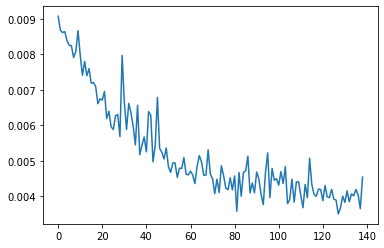

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>)


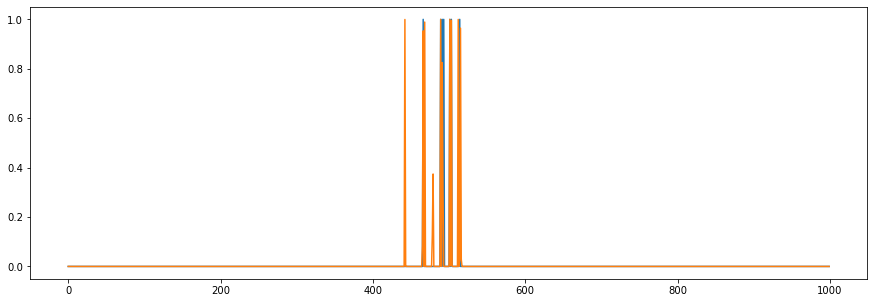

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_aSoma/na_true_late/gru_l20_h40_10ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_aSoma/na_true_late/gru_l20_h40_10ms_test.npy", test_S_out.cpu().detach().numpy())